<a href="https://colab.research.google.com/github/pablopuch/Sagulpa/blob/main/Sagulpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAGULPA – Previsión de entradas y salidas

El objeto de esta activad es realizar una predicción del número de entradas y salidas en los aparcamientos gestionados por SAGULPA en un día del año. Para lo cual utilizaremos los datos abiertos publicados en su web.

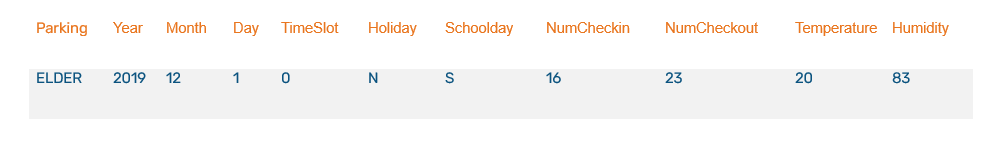

## Datos:


*   Parking: Lugar de cada parking
*   Year: año
*   Month: mes
*   Day: día
*   Timeslot: Hora (el rango es de 0 a 23)
*   Holiday: Dia Festivo (se marca con una "S" si es festivo y si no "N")
*   Schoolday: Día lectivo (se marca con una "S" si es lectivo y si no "N")
*   NumCheckin: Numero de entradas (filtrado ese dia, a esa hora, y en ese parking)
*   NumCheckout: Numero de salidas (filtrado ese dia, a esa hora, y en ese parking)
*   Temperature: Temperatura (filtrado de ese dia a esa hora)
*   Humidity: Mumedad (filtrado de ese dia a esa hora)




---



# TRABAJO CON LOS DATOS

In [64]:
!pip install scikit-learn==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import pickle
import pandas as pd
# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
# cargamos el excel y mostramos informacíon de las tablas
datos = 'APARCAMIENTOS-DICIEMBRE-2019.csv'
df = pd.read_csv(datos)
df

,GarageNo,APARCAMIENTO,EventTime,EventDesc
0,8855,ELDER,2019-12-01 00:37:16,Salida
1,8855,ELDER,2019-12-01 01:17:08,Salida
2,8855,ELDER,2019-12-01 03:06:42,Salida
3,8855,ELDER,2019-12-01 08:09:06,Entrada
4,8855,ELDER,2019-12-01 10:43:24,Salida
...,...,...,...,...
276159,8601,VEGUETA,2019-12-31 23:10:18,Entrada
276160,8601,VEGUETA,2019-12-31 23:28:00,Salida
276161,8601,VEGUETA,2019-12-31 23:28:24,Entrada
276162,8601,VEGUETA,2019-12-31 23:29:52,Salida


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276164 entries, 0 to 276163
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   GarageNo      276164 non-null  int64 
 1   APARCAMIENTO  276164 non-null  object
 2   EventTime     276164 non-null  object
 3   EventDesc     276164 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.4+ MB


In [68]:
# eliminamos la columna GarageNo del df
df = df.drop(['GarageNo'], axis=1)

# cambiar en nombre a las comlumna de APARCAMIENTO
df = df.rename(columns={'APARCAMIENTO': 'parking'})

df['EventTime'] = pd.to_datetime(df['EventTime'], format='%Y-%m-%d %H:%M:%S')

# separamos la colunna EventTime por año, mes, dia y hora
df['year'] = df['EventTime'].dt.year
df['month'] = df['EventTime'].dt.month
df['day'] = df['EventTime'].dt.day
df['timeslot'] = df['EventTime'].dt.hour

# creamos una nueva columna con el nombre del dia
df['dayweek'] = df['EventTime'].dt.day_name()
df['dayweek'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],['L', 'M', 'X', 'J', 'V', 'S', 'D'], inplace=True)
df

,parking,EventTime,EventDesc,year,month,day,timeslot,dayweek
0,ELDER,2019-12-01 00:37:16,Salida,2019,12,1,0,D
1,ELDER,2019-12-01 01:17:08,Salida,2019,12,1,1,D
2,ELDER,2019-12-01 03:06:42,Salida,2019,12,1,3,D
3,ELDER,2019-12-01 08:09:06,Entrada,2019,12,1,8,D
4,ELDER,2019-12-01 10:43:24,Salida,2019,12,1,10,D
...,...,...,...,...,...,...,...,...
276159,VEGUETA,2019-12-31 23:10:18,Entrada,2019,12,31,23,M
276160,VEGUETA,2019-12-31 23:28:00,Salida,2019,12,31,23,M
276161,VEGUETA,2019-12-31 23:28:24,Entrada,2019,12,31,23,M
276162,VEGUETA,2019-12-31 23:29:52,Salida,2019,12,31,23,M


In [69]:
import holidays

# definir fecha y pais del calendario de festivos
calendario = holidays.Spain(years=2019)

# definir días festivos de un mes especifico
festivos = []
for date in calendario:
    if date.month == 12:  # mes de diciembre
        festivos.append(date)

# Definir función para determinar si una fecha es festiva o no
def es_festivo(fecha):
    if fecha in festivos:
      return 'S'
    else:
      return 'N'

# Crear columna "es_festivo" en el dataframe
df['holiday'] = df['EventTime'].apply(es_festivo)
df

<ipython-input-69-0c995603fd70>:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if fecha in festivos:


,parking,EventTime,EventDesc,year,month,day,timeslot,dayweek,holiday
0,ELDER,2019-12-01 00:37:16,Salida,2019,12,1,0,D,N
1,ELDER,2019-12-01 01:17:08,Salida,2019,12,1,1,D,N
2,ELDER,2019-12-01 03:06:42,Salida,2019,12,1,3,D,N
3,ELDER,2019-12-01 08:09:06,Entrada,2019,12,1,8,D,N
4,ELDER,2019-12-01 10:43:24,Salida,2019,12,1,10,D,N
...,...,...,...,...,...,...,...,...,...
276159,VEGUETA,2019-12-31 23:10:18,Entrada,2019,12,31,23,M,N
276160,VEGUETA,2019-12-31 23:28:00,Salida,2019,12,31,23,M,N
276161,VEGUETA,2019-12-31 23:28:24,Entrada,2019,12,31,23,M,N
276162,VEGUETA,2019-12-31 23:29:52,Salida,2019,12,31,23,M,N


In [70]:
import datetime

# Crear fecha inicial
fecha_inicial = datetime.date(2019, 12, 21)

# Crear fecha final
fecha_final = datetime.date(2019, 12, 31)

# Crear rango de fechas
rango_fechas = [fecha_inicial + datetime.timedelta(days=d) for d in range((fecha_final - fecha_inicial).days + 1)]

# Añadir días festivos y sabado y domingo
rango_fechas.append(datetime.date(2019, 12, 6))
rango_fechas.append(datetime.date(2019, 12, 9))
rango_fechas.append(datetime.date(2019, 12, 1))
rango_fechas.append(datetime.date(2019, 12, 7))
rango_fechas.append(datetime.date(2019, 12, 8))
rango_fechas.append(datetime.date(2019, 12, 14))
rango_fechas.append(datetime.date(2019, 12, 15))


# Imprimir rango de fechas
rango_fechas

[datetime.date(2019, 12, 21),
 datetime.date(2019, 12, 22),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 24),
 datetime.date(2019, 12, 25),
 datetime.date(2019, 12, 26),
 datetime.date(2019, 12, 27),
 datetime.date(2019, 12, 28),
 datetime.date(2019, 12, 29),
 datetime.date(2019, 12, 30),
 datetime.date(2019, 12, 31),
 datetime.date(2019, 12, 6),
 datetime.date(2019, 12, 9),
 datetime.date(2019, 12, 1),
 datetime.date(2019, 12, 7),
 datetime.date(2019, 12, 8),
 datetime.date(2019, 12, 14),
 datetime.date(2019, 12, 15)]

In [71]:
# Definir función para determinar si una fecha es lectiva o no
def es_lectivo(fecha):
    if fecha in rango_fechas:
      return 'N'
    else:
      return 'S'

# Crear columna "es_lectivo" en el dataframe
df['schoolday'] = df['EventTime'].apply(es_lectivo)
df

<ipython-input-71-c5b2a2eda642>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if fecha in rango_fechas:


,parking,EventTime,EventDesc,year,month,day,timeslot,dayweek,holiday,schoolday
0,ELDER,2019-12-01 00:37:16,Salida,2019,12,1,0,D,N,N
1,ELDER,2019-12-01 01:17:08,Salida,2019,12,1,1,D,N,N
2,ELDER,2019-12-01 03:06:42,Salida,2019,12,1,3,D,N,N
3,ELDER,2019-12-01 08:09:06,Entrada,2019,12,1,8,D,N,N
4,ELDER,2019-12-01 10:43:24,Salida,2019,12,1,10,D,N,N
...,...,...,...,...,...,...,...,...,...,...
276159,VEGUETA,2019-12-31 23:10:18,Entrada,2019,12,31,23,M,N,N
276160,VEGUETA,2019-12-31 23:28:00,Salida,2019,12,31,23,M,N,N
276161,VEGUETA,2019-12-31 23:28:24,Entrada,2019,12,31,23,M,N,N
276162,VEGUETA,2019-12-31 23:29:52,Salida,2019,12,31,23,M,N,N


In [72]:
# creamos un dos columnas para contavilizar las entradas y salidas y las inicializamos a cero
df['numcheckin'] = 0
df['numcheckout'] = 0

# recoremos el df y vamos colocontando un 1 en la conlumna que le coresponde
# si es Entrada se coloca un 1 en la columna numcheckin
# y si es Salida se coloca un 1 en la columna numcheckout
for i, row in df.iterrows():
    if row['EventDesc'] == 'Entrada':
        df.at[i, 'numcheckin'] = 1
    elif row['EventDesc'] == 'Salida':
        df.at[i, 'numcheckout'] = 1
df

,parking,EventTime,EventDesc,year,month,day,timeslot,dayweek,holiday,schoolday,numcheckin,numcheckout
0,ELDER,2019-12-01 00:37:16,Salida,2019,12,1,0,D,N,N,0,1
1,ELDER,2019-12-01 01:17:08,Salida,2019,12,1,1,D,N,N,0,1
2,ELDER,2019-12-01 03:06:42,Salida,2019,12,1,3,D,N,N,0,1
3,ELDER,2019-12-01 08:09:06,Entrada,2019,12,1,8,D,N,N,1,0
4,ELDER,2019-12-01 10:43:24,Salida,2019,12,1,10,D,N,N,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
276159,VEGUETA,2019-12-31 23:10:18,Entrada,2019,12,31,23,M,N,N,1,0
276160,VEGUETA,2019-12-31 23:28:00,Salida,2019,12,31,23,M,N,N,0,1
276161,VEGUETA,2019-12-31 23:28:24,Entrada,2019,12,31,23,M,N,N,1,0
276162,VEGUETA,2019-12-31 23:29:52,Salida,2019,12,31,23,M,N,N,0,1


In [73]:
# agrupamos los las filas para no tener tantas filas repitiendo datos
df_sagulpa = df.groupby(['parking', 'day', 'month', 'year', 'dayweek', 'timeslot', 'holiday', 'schoolday'], as_index=False)[['numcheckin', 'numcheckout']].sum()
df_sagulpa

,parking,day,month,year,dayweek,timeslot,holiday,schoolday,numcheckin,numcheckout
0,ELDER,1,12,2019,D,0,N,N,16,23
1,ELDER,1,12,2019,D,1,N,N,8,25
2,ELDER,1,12,2019,D,2,N,N,1,22
3,ELDER,1,12,2019,D,3,N,N,1,23
4,ELDER,1,12,2019,D,4,N,N,0,10
...,...,...,...,...,...,...,...,...,...,...
4274,VEGUETA,31,12,2019,M,19,N,N,14,44
4275,VEGUETA,31,12,2019,M,20,N,N,11,20
4276,VEGUETA,31,12,2019,M,21,N,N,10,8
4277,VEGUETA,31,12,2019,M,22,N,N,1,3


In [74]:
# importamos el csv de datos del tiempo ya tratados
df_clima = pd.read_csv('CLIMA-DICIEMBRE-2019.csv')
df_clima

,Hora,Temperatura,Humedad,Dia
0,0,20,83,1
1,1,20,83,1
2,2,20,78,1
3,3,20,78,1
4,4,19,83,1
...,...,...,...,...
738,19,18,59,31
739,20,17,48,31
740,21,17,45,31
741,22,18,24,31


In [75]:
# Recorremos el df_segulpa con dos condiciones, que son dia y hora
# si coinciden los dos pues añade los datos de las columnas Temp. y Humed.
# a su respectiva columna.

for index, row in df_sagulpa.iterrows():
    match = df_clima[(df_clima['Dia'] == row['day']) & (df_clima['Hora'] == row['timeslot'])]
    if not match.empty:
        df_sagulpa.loc[index, 'temperature'] = match.iloc[0]['Temperatura']
        df_sagulpa.loc[index, 'humidity'] = match.iloc[0]['Humedad']

df_sagulpa

,parking,day,month,year,dayweek,timeslot,holiday,schoolday,numcheckin,numcheckout,temperature,humidity
0,ELDER,1,12,2019,D,0,N,N,16,23,20.0,83.0
1,ELDER,1,12,2019,D,1,N,N,8,25,20.0,83.0
2,ELDER,1,12,2019,D,2,N,N,1,22,20.0,78.0
3,ELDER,1,12,2019,D,3,N,N,1,23,20.0,78.0
4,ELDER,1,12,2019,D,4,N,N,0,10,19.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4274,VEGUETA,31,12,2019,M,19,N,N,14,44,18.0,59.0
4275,VEGUETA,31,12,2019,M,20,N,N,11,20,17.0,48.0
4276,VEGUETA,31,12,2019,M,21,N,N,10,8,17.0,45.0
4277,VEGUETA,31,12,2019,M,22,N,N,1,3,18.0,24.0


**¿Por que eliminamos el Parking de SAN BERNARDO?**

Durante ese año en ese mes el parking, ha estado cerrado y por lo tanto no a estado operativo para los usuarios. Eso se traduce que no a tenido ni entradas ni salidas.

La decisicion que he tomado a sido la de elminar ese parking por motivos de fiavilidad a la hora de entrenar.
[Noticia](https://www.laprovincia.es/las-palmas/2019/12/20/abre-parquin-san-bernardo-9187319.html)

Nota: En futuras itareracíones se podria coger otro mes de otro año como Diciembre del 2021, o otro mes distinto.

In [76]:
# eliminamos el parking SAN BERNARDO
df_sagulpa = df_sagulpa[df_sagulpa['parking'] != 'SAN BERNARDO']
df_sagulpa['parking'].unique()

array(['ELDER', 'MATA', 'METROPOL', 'RINCON', 'SANAPU', 'VEGUETA'],
      dtype=object)

In [77]:
# mostramos el df_sagulpa
df_sagulpa

,parking,day,month,year,dayweek,timeslot,holiday,schoolday,numcheckin,numcheckout,temperature,humidity
0,ELDER,1,12,2019,D,0,N,N,16,23,20.0,83.0
1,ELDER,1,12,2019,D,1,N,N,8,25,20.0,83.0
2,ELDER,1,12,2019,D,2,N,N,1,22,20.0,78.0
3,ELDER,1,12,2019,D,3,N,N,1,23,20.0,78.0
4,ELDER,1,12,2019,D,4,N,N,0,10,19.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4274,VEGUETA,31,12,2019,M,19,N,N,14,44,18.0,59.0
4275,VEGUETA,31,12,2019,M,20,N,N,11,20,17.0,48.0
4276,VEGUETA,31,12,2019,M,21,N,N,10,8,17.0,45.0
4277,VEGUETA,31,12,2019,M,22,N,N,1,3,18.0,24.0


Tuvimos que calcular la media de la media de algunas columnas por falta de datos en ciertas filas sobre todo en los dias 19 a las 21.

In [78]:
df_sagulpa[['temperature','humidity']] = df_sagulpa[['temperature','humidity']].fillna(method='pad')

<ipython-input-78-d490810692aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sagulpa[['temperature','humidity']] = df_sagulpa[['temperature','humidity']].fillna(method='pad')


In [79]:
# mostramos el df_sagulpa
df_sagulpa

,parking,day,month,year,dayweek,timeslot,holiday,schoolday,numcheckin,numcheckout,temperature,humidity
0,ELDER,1,12,2019,D,0,N,N,16,23,20.0,83.0
1,ELDER,1,12,2019,D,1,N,N,8,25,20.0,83.0
2,ELDER,1,12,2019,D,2,N,N,1,22,20.0,78.0
3,ELDER,1,12,2019,D,3,N,N,1,23,20.0,78.0
4,ELDER,1,12,2019,D,4,N,N,0,10,19.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4274,VEGUETA,31,12,2019,M,19,N,N,14,44,18.0,59.0
4275,VEGUETA,31,12,2019,M,20,N,N,11,20,17.0,48.0
4276,VEGUETA,31,12,2019,M,21,N,N,10,8,17.0,45.0
4277,VEGUETA,31,12,2019,M,22,N,N,1,3,18.0,24.0


# GRAFICAS

En la siguiente gráfica se muestra por parking las entradas y salidas de conjunto total de los días de la semana.

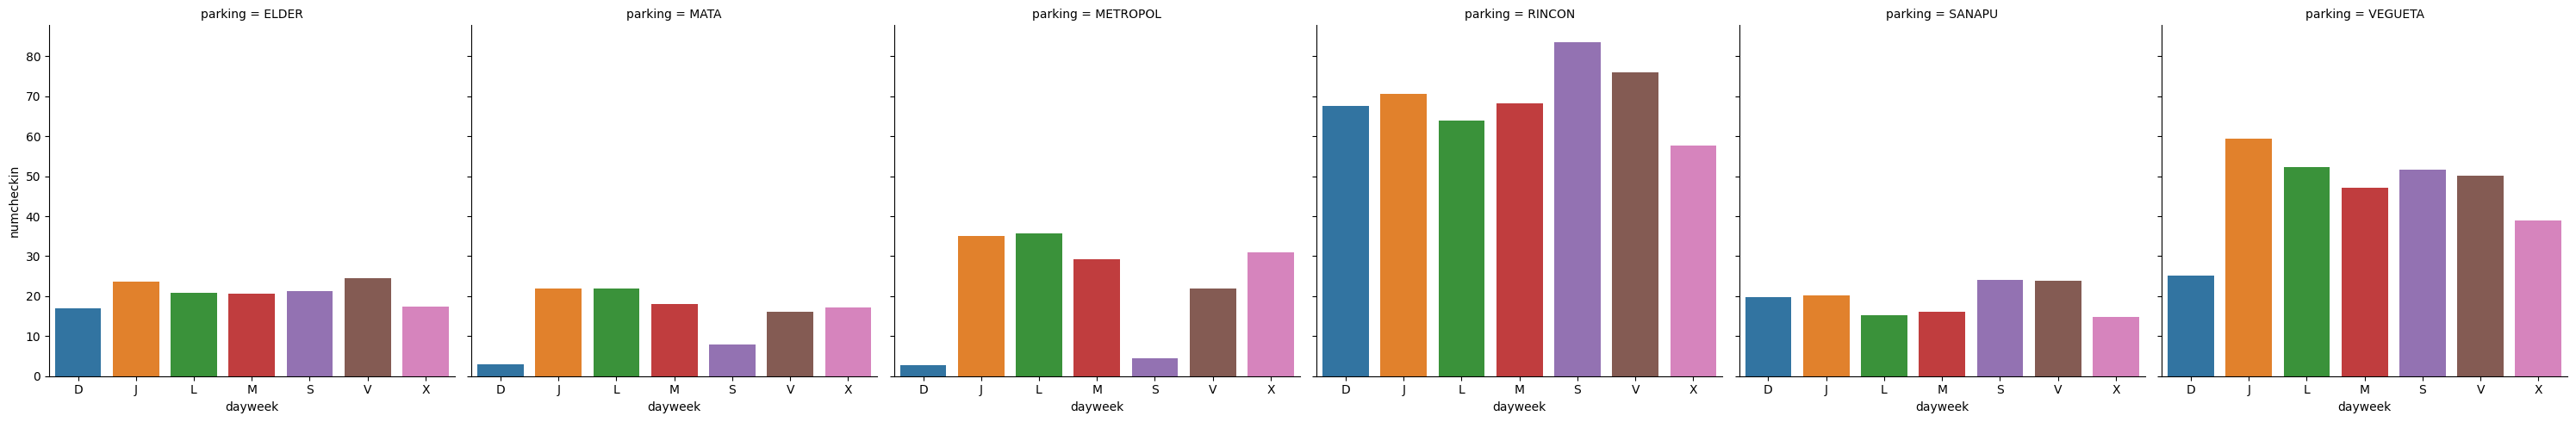

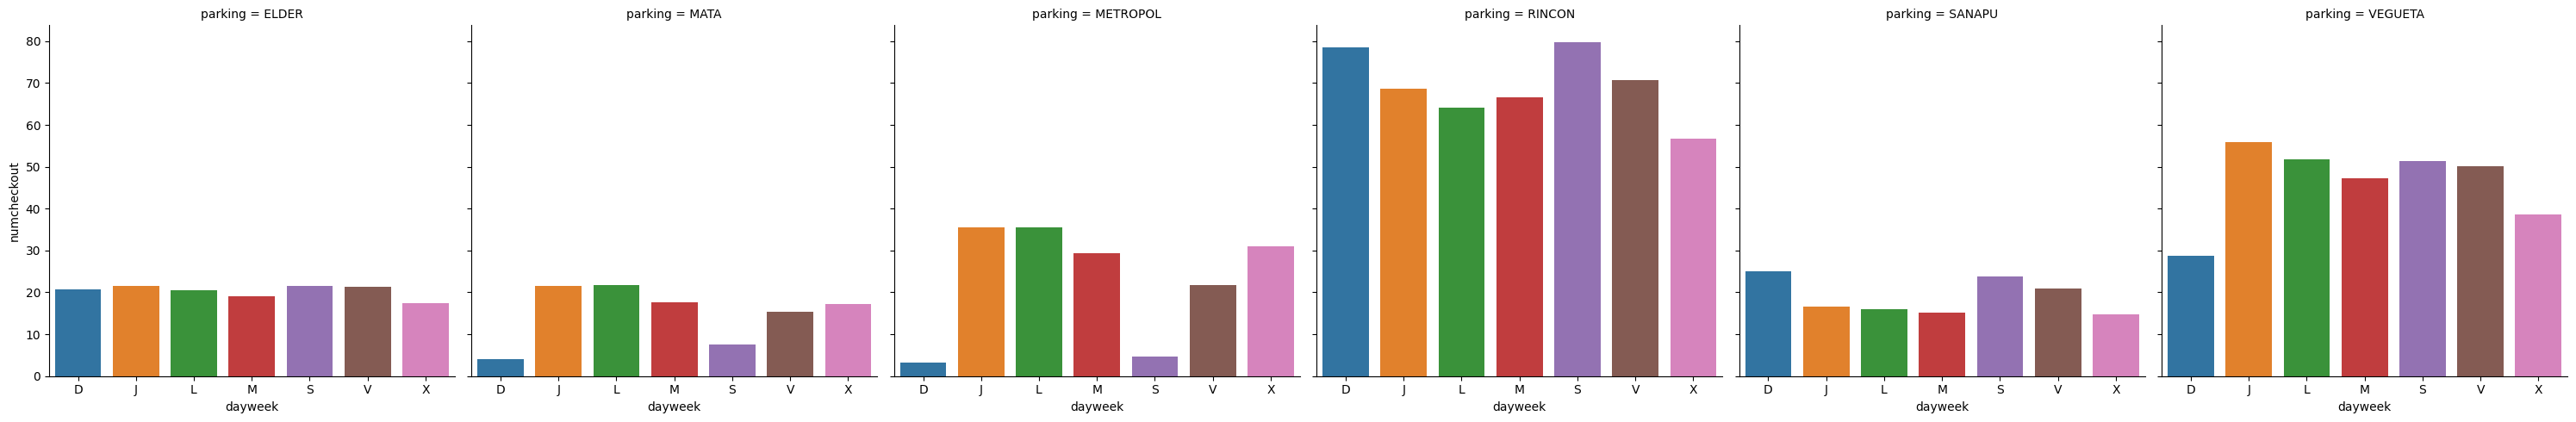

In [80]:
import seaborn as sns

# Agrupar los datos por parking y día de la semana, calculando la media de los campos numcheckin y numcheckout
df_mean = df_sagulpa.groupby(['parking', 'dayweek'], as_index=False)[['numcheckin', 'numcheckout']].mean()

# Crear una gráfica de barras con Seaborn
sns.catplot(data=df_mean, x='dayweek', y='numcheckin', col='parking', kind='bar')
sns.catplot(data=df_mean, x='dayweek', y='numcheckout', col='parking', kind='bar')


En esta otra se muestra las horas puntas de entrada y salida del mes por parking.

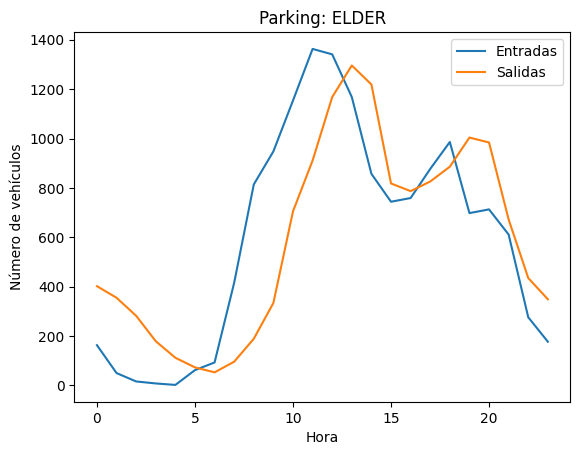

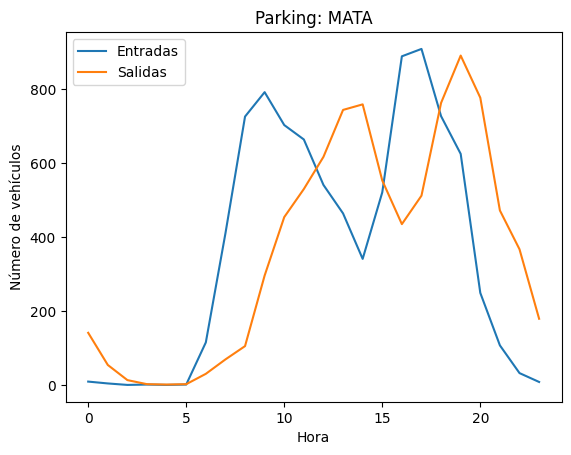

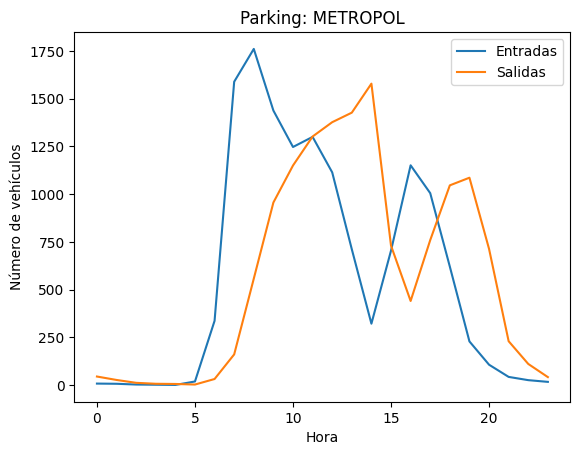

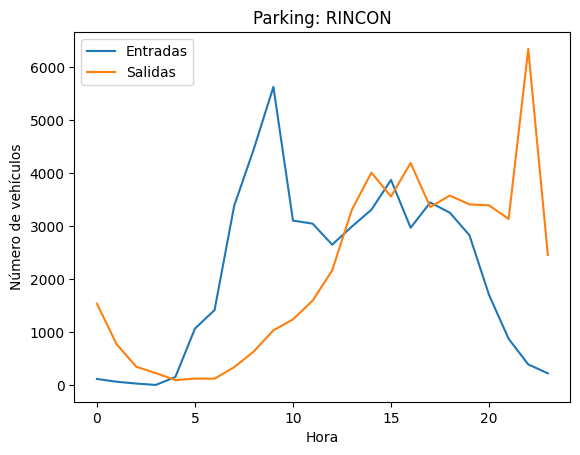

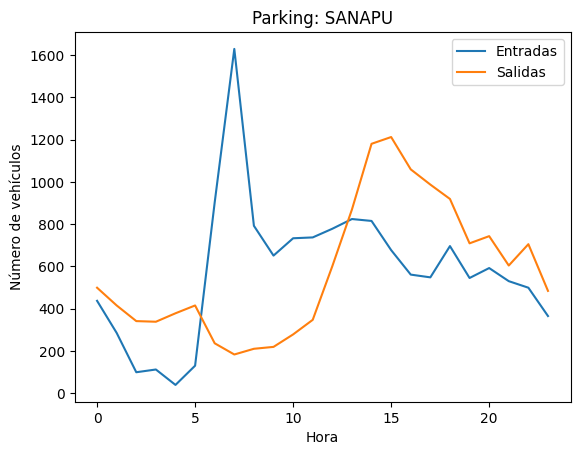

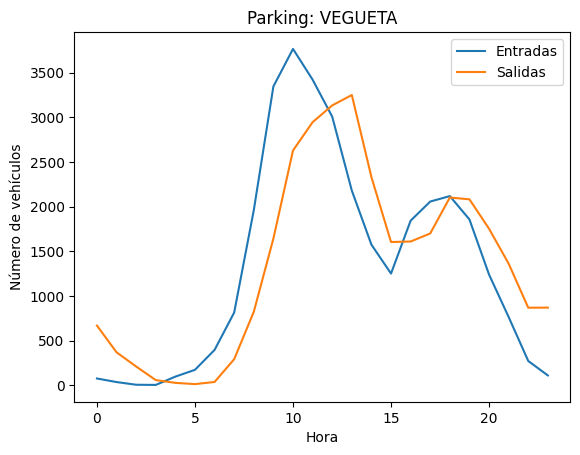

In [81]:
import matplotlib.pyplot as plt

# Obtenemos una lista con los nombres de los parkings
parkings = df_sagulpa['parking'].unique()

# Iteramos por cada parking
for parking in parkings:
    # Filtramos los datos correspondientes al parking actual
    data = df_sagulpa[df_sagulpa['parking'] == parking]
    
    # Agrupamos los datos por hora y sumamos las entradas y salidas de vehículos
    data_hora = data.groupby(['timeslot'], as_index=False)[['numcheckin', 'numcheckout']].sum()
    
    # Creamos la figura y los ejes
    fig, ax = plt.subplots()
    
    # Configuramos los ejes
    ax.set_title('Parking: {}'.format(parking))
    ax.set_xlabel('Hora')
    ax.set_ylabel('Número de vehículos')
    
    # Creamos las líneas correspondientes a las entradas y salidas de vehículos
    ax.plot(data_hora['timeslot'], data_hora['numcheckin'], label='Entradas')
    ax.plot(data_hora['timeslot'], data_hora['numcheckout'], label='Salidas')
    
    # Añadimos la leyenda
    ax.legend()
    
    # Mostramos la gráfica
    plt.show()


# PREPARAR EL DF PARA LOS MODELOS

In [82]:
df_sagulpa.columns

Index(['parking', 'day', 'month', 'year', 'dayweek', 'timeslot', 'holiday',
       'schoolday', 'numcheckin', 'numcheckout', 'temperature', 'humidity'],
      dtype='object')

In [83]:
df_sagulpa['parking'].unique()

array(['ELDER', 'MATA', 'METROPOL', 'RINCON', 'SANAPU', 'VEGUETA'],
      dtype=object)

In [84]:
# combertimos todos los datos de letras a numericos
df_sagulpa['dayweek'].replace(['L', 'M', 'X', 'J', 'V', 'S', 'D'],[1, 2, 3, 4, 5, 6, 7], inplace=True) 
df_sagulpa['parking'].replace(['ELDER', 'MATA', 'METROPOL', 'RINCON', 'SANAPU', 'VEGUETA'],[1, 2, 3, 4, 5, 6], inplace=True)
df_sagulpa['holiday'].replace(['N', 'S'],[0, 1], inplace=True)
df_sagulpa['schoolday'].replace(['N', 'S'],[0, 1], inplace=True)

<ipython-input-84-d345bad5da4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sagulpa['dayweek'].replace(['L', 'M', 'X', 'J', 'V', 'S', 'D'],[1, 2, 3, 4, 5, 6, 7], inplace=True)
<ipython-input-84-d345bad5da4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sagulpa['parking'].replace(['ELDER', 'MATA', 'METROPOL', 'RINCON', 'SANAPU', 'VEGUETA'],[1, 2, 3, 4, 5, 6], inplace=True)
<ipython-input-84-d345bad5da4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [85]:
cols_to_convert =['parking', 'day', 'month', 'year', 'dayweek', 'timeslot', 'holiday','schoolday', 'temperature', 'humidity']
df_sagulpa[cols_to_convert] = df_sagulpa[cols_to_convert].astype(float)

<ipython-input-85-05e73b2978fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sagulpa[cols_to_convert] = df_sagulpa[cols_to_convert].astype(float)


# Empezamos a trabajar modelo(entradas)

### Árbol de dicción con AdaBoostRegressor con GridSearchCV

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

In [87]:
# Dividimos los datos de entrenamiento 
X_Train = df_sagulpa.drop(['numcheckin', 'numcheckout'], axis=1)
Y_Train = df_sagulpa['numcheckin']

In [88]:
regressor = RandomForestRegressor() 
regressor

RandomForestRegressor()

In [89]:
param_dist = {"n_estimators": [2, 4, 8, 16, 32], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features (características) when looking for the best split (división)
              "max_depth": [8,4, 2], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16], # Minimum number of samples required at each leaf(hoja) node
              "bootstrap": [False] # Method of selecting for training each tree, If False, the whole dataset is used to build each tree.
            }

In [90]:
# Como saber el número de combinaciones de parámetros que se van a ejecutar
num_combinations = 1
for param in param_dist:
    num_combinations *= len(param_dist[param])
print(f'El número total de combinaciones de parámetros en GridSearchCV es {num_combinations}')

El número total de combinaciones de parámetros en GridSearchCV es 270


In [91]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 5)
model = grid_regres.fit(X_Train, Y_Train)

In [92]:
data22 = pd.read_csv('sagulpa_2022.csv')
data22X = X_Train = df_sagulpa.drop(['numcheckin', 'numcheckout'], axis=1)
data22Y = Y_Train = df_sagulpa['numcheckout']

In [94]:
Y_Pred = grid_regres.predict(data22X)
score = mean_absolute_error(data22Y, Y_Pred)
score

21.002671966292976

In [95]:
x_in = np.asarray([4.0,	1.0,	12.0,	2022.0,	2.0,	10.0,	0.0,	1.0, 20.0,	83.0]).reshape(1,-1)
predicts = model.predict(x_in)
predicts[0]

124.61538461538461

In [96]:
# Grabamos el modelo en el directorio
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Cargamos el modelo
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)